# MuData showcase

Here we demonstrate that all of our main functions, including preprocessing, model selection, loading models, and retrieving the latent representation, seamlessly support MuData objects as well. This notebook combines functionalities from both 01_preprocessing and 02_training_analysis. We start by generating a dataset, converting it to a MuData object, preprocessing it with the same functions, and then conducting our training analysis, which includes model selection and retrieving the latent representation.

<span style="color:red">Please note:</span> \
If you call the functions with MuData objects, ensure that you provide the MuData object as the first argument and the subsequent arguments as keyword arguments: \
```function(mudata, first_arg=first_param, second_arg=second_param, ...)```\
Otherwise, functionality may not be supported. 

In [1]:
import comet_ml # comet-ml must be imported before torch and sklearn
import pandas as pd
import scanpy as sc
import muon as mu
import scirpy as ir
import awkward as ak

from mvtcr.utils_preprocessing import Preprocessing
import mvtcr.utils_training as utils
utils.fix_seeds(42) #This sets torch.manual_seed, np.random.seed, random.seed for reproducibility; optuna sampler seed can be set later

c:\Users\Jan\.conda\envs\mvtcr_n3\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path_gex = '../data/Haniffa/haniffa21.processed.h5ad'
path_tcr = '../data/Haniffa/TCR_merged-Updated'

adata = sc.read(path_gex)

selected_patients = ['AP1', 'CV0062']
adata = adata[adata.obs['patient_id'].isin(selected_patients)].copy()

In [3]:
adata.X = adata.layers['raw']
print(adata.X[0:4,11:20].toarray())
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
print(adata.X[0:4,11:20].toarray())

[[1. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 2. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0.]]
[[1.1596017 0.        0.        0.        0.        1.1596017 0.
  0.        0.       ]
 [0.        0.        0.        0.        0.        1.52811   0.
  0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.
  0.        0.       ]
 [0.        0.        0.        0.        0.        0.        0.
  0.        0.       ]]


In [4]:
print('Shape before: ', adata.shape)
sc.pp.highly_variable_genes(adata, n_top_genes=5000)
adata = adata[:, adata.var['highly_variable']]
print('Shape after: ', adata.shape)

Shape before:  (8811, 24929)
Shape after:  (8811, 5000)


In [5]:
df_tcr = pd.read_csv(f'{path_tcr}.tsv', sep='\t')
df_tcr['barcode'] = df_tcr.pop('CellID') # change cell IDs column name to "barcode"
df_tcr = df_tcr[df_tcr['study_id'].isin(selected_patients)] # keep only selected patients
df_tcr.to_csv(f'{path_tcr}.csv')

In [6]:
adata_tcr = ir.io.read_10x_vdj(f'{path_tcr}.csv') # load with scirpy

barcode2idx = {barcode: i for i, barcode in enumerate(adata_tcr.obs_names)}
idx = [barcode2idx.get(barcode) for barcode in adata.obs_names]

adata.obsm["airr"] = adata_tcr.obsm["airr"][idx]
adata = adata[~ak.is_none(adata.obsm['airr']).to_numpy()]

In [7]:
ir.pp.index_chains(adata)

100%|██████████| 2/2 [00:02<00:00,  1.27s/it]


In [8]:
print(len(adata))
junction_aa = ir.get.airr(adata, "junction_aa")
adata = adata[~(junction_aa['VJ_1_junction_aa'].isna() | junction_aa['VDJ_1_junction_aa'].isna())]
print(len(adata))

5395
4227


In [9]:
mdata = Preprocessing.adata_to_mudata(adata, obs_cols=[], obsm_cols=["airr", "chain_indices"], uns_cols=["chain_indices"])
mdata

MuData object with n_obs × n_vars = 4227 × 5000
  2 modalities
    gex:	4227 x 5000
      obs:	'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id'
      var:	'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg', 'leiden', 'neighbors', 'pca', 'umap', 'log1p'
      obsm:	'X_pca', 'X_pca_harmony', 'X_umap'
      layers:	'raw'
    airr:	4227 x 0
      uns:	'chain_indices'
      obsm:	'airr', 'chain_indices'

### Checking if adata is in a mvTCR compatible shape

In [10]:
if Preprocessing.check_if_valid_adata(mdata):
    print("Valid")

MuData as input detected.


Valid


### Encoding clonotypes with Scirpy

For training the shared embedding, we advise oversampling rare clonotypes. This avoids the model overfitting to few selected TCR sequences from highly expanded clonotypes. Therefore, we need to add a clonotype label to adata.obs. Here, we define a unique clonotype via Scirpy as having exactly the same CDR3 sequence in TRA and TRB chains.

In [11]:
Preprocessing.encode_clonotypes(mdata, key_added="clonotype")
mdata["airr"].obs["clonotype"].value_counts()

MuData as input detected.


100%|██████████| 4049/4049 [00:06<00:00, 599.49it/s]


clonotype
2251    32
2207    25
2527     8
326      7
3277     7
        ..
1374     1
1375     1
1376     1
1377     1
4048     1
Name: count, Length: 4049, dtype: int64

### Adding TCR encoding

Next, we encode the TCR sequence numerically to adata.obsm. Here, we need to provide the name of the column storing the CDR3a and CDR3b. Additionally, we need to specificy the padding paremter (which if set to None uses the maximal CDR3 sequence length as default). If you plan to add new data in the future via a pretrained model, you might want to add some safety margin.

In [12]:
Preprocessing.encode_tcr(mdata, 
                         airr_name='junction_aa', 
                         alpha_label_key='alpha_seq', 
                         alpha_length_key='alpha_len',
                         beta_label_key='beta_seq', 
                         beta_length_key='beta_len')

mdata["airr"].obsm['beta_seq'][:5]

MuData as input detected.


array([[ 2,  1,  1, 18, 12, 12, 12,  1,  6, 12, 11, 10, 17,  5,  0,  0,
         0,  0,  0,  0,  0,  0],
       [ 2,  1, 18,  3, 17,  6,  6,  6, 12,  9, 10, 17,  5,  0,  0,  0,
         0,  0,  0,  0,  0,  0],
       [ 2, 18, 18, 11, 13,  5,  6,  6, 20, 14,  9, 18, 17,  5,  0,  0,
         0,  0,  0,  0,  0,  0],
       [ 2,  8, 18, 15,  6, 18, 16, 15,  1, 15, 10, 11,  5,  0,  0,  0,
         0,  0,  0,  0,  0,  0],
       [ 2,  1,  1, 13, 17, 16,  6, 17, 20,  9, 20,  8,  5,  0,  0,  0,
         0,  0,  0,  0,  0,  0]])

### Adding conditional variables

Conditioning your model partially removes the effect from a specified condition. We can add conditional variables for e.g. donor, to avoid batch effects over multiple samples.

In [13]:
Preprocessing.encode_conditional_var(mdata, column_id='patient_id')
mdata.obsm['patient_id_ohe']

MuData as input detected.


array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

### Creating training and validation splits

The splitting improves the data spliting into training and validation sets by two properties:
- Stratified splitting: balance a label of interest (normally a variable to be predicted, e.g. antigen specificity) so the label distribution is roughly the same in both sets.
- Avoid training data leakage into validation: used for clonotypes, to ensure that each clonotype is observed only during training or validation.

In [14]:
train, val = Preprocessing.stratified_group_shuffle_split(mdata, stratify_col='full_clustering', group_col='clonotype', test_size=0.2, random_seed=42)

mdata.obs['set'] = 'train'
mdata.obs.loc[val, 'set'] = 'val'

mdata.obs["set"].value_counts()

MuData as input detected.


100%|██████████| 23/23 [00:00<00:00, 328.57it/s]


set
train    3357
val       870
Name: count, dtype: int64

Alternatively group splitting is available by itself with:

In [15]:
train, val = Preprocessing.group_shuffle_split(mdata, group_col='clonotype', test_size=0.2, random_seed=42)

mdata.obs['set'] = 'train'
mdata.obs.loc[val, 'set'] = 'val'

mdata.obs["set"].value_counts()

MuData as input detected.


set
train    3384
val       843
Name: count, dtype: int64

In [16]:
mdata

MuData object with n_obs × n_vars = 4227 × 5000
  obs:	'set'
  uns:	'patient_id_enc'
  obsm:	'patient_id_ohe'
  2 modalities
    gex:	4227 x 5000
      obs:	'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id'
      var:	'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg', 'leiden', 'neighbors', 'pca', 'umap', 'log1p'
      obsm:	'X_pca', 'X_pca_harmony', 'X_umap'
      layers:	'raw'
    airr:	4227 x 0
      obs:	'receptor_type', 'receptor_subtype', 'chain_pairing', 'clonotype', 'clonotype_size', 'alpha_len', 'beta_len'
      uns:	'chain_indices', 'ir_dist_nt_identity', 'clonotype', 'aa_to_id'
      obsm:	'airr', 'chain_indices', 'alpha_seq', 'beta_seq'

In [ ]:
# This also works for the pipeline
Preprocessing.preprocessing_pipeline(mdata, 
                                     clonotype_key_added='clonotype', 
                                     airr_name='junction_aa',
                                     cond_vars=['patient_id'])

# Training the model for Analysis
In this notebook, we will explain how to train your model with the objective of dataset analysis. Here, we optimize to conserve multiple annotations at the same time (e.g. clonotype and cell type, as a surrogate of Gene Expression). You can determine the influence of both modalities (TCR via clonotype, GEX via cell types) by specifying a weight for annotation. This might require retraining on a couple of weight values for finding a mixture suitable for your analysis.

## Defining the model parameters
We need to proivde the model a couple of parameters:
- study_name: Name for logging
- comet_workspace: we logged some of the experiments via Comet-ML. This gives you more information on the training process, but is not needed. We will therefore use None here. Otherwise, specifiy the workspace name of your Comet-ML project.
- model_name: assigns which model is used from (rna, tcr, moe, poe, concat). We will use the best performing moe.
- balanced_sample: oversample rare elements of this column. Recommended to use a column storing the clonotype to avoid overfitting.
- metadata: annotation to color the umaps when storing immediate results on Comet-ML. If no Comet-ML is used, pass an empty list
- save_path: path to store the trained models over multiple training runs
- conditional: name of a conditional variable (see preprocessing). The model partially removes batch effects over this column.
- n_epoch: amounts of epochs to train the model. For the paper we used 200 epochs. For showcasing however, we will reduce it to 5.

In [17]:
params_experiment = {
    'study_name': 'haniffa_mudata_tutorial',
    'comet_workspace': None, 
    'model_name': 'moe',
    'balanced_sampling': 'clonotype',
    'metadata': [],
    'save_path': '../saved_models/haniffa_mudata_tutorial',
    'conditional': 'patient_id_ohe',
    'n_epochs': 10,
}

## Defining Optimization parameters
For this analysis, we will optimize to perserve clonotype and cell type ("full_clustering" column in our dataset). This optimization mode is called 'pseudo_metric'. By specifying the weight, we can choose the weighting between both modalities.

In [18]:
params_optimization = {
    'name': 'pseudo_metric',
    'prediction_labels':
        {'clonotype': 1,
         'full_clustering': 1}
}

We also offer the option to exclude cells from evaluation, but not training. To do so, set the value of the prediction label for the desired cells to -99 (in your adata object, not here in the params dict!).

## Calling the training functions
Finally, we need to specificy a couple of parameters for running the training. Training will be aborted either after \<timeout\> seconds or after having trained 3 models with 1 available GPU. Typically, we used considerable larger amount of training runs (e.g. 48 GPU-hours). Note: when increasing the number of GPUs, you will also need to scale the CPU resources, so that the training is not bottlenecked by e.g. dataloading on CPU. The argument sampler_seed can be specified make the optuna sampler behave deterministically. However, for fully reproducible results training should be run sequentially https://optuna.readthedocs.io/en/stable/faq.html.  

In [19]:
from mvtcr.models.model_selection import run_model_selection

timeout = (20*60)
n_samples = 3
n_gpus = 1
seed = 42
run_model_selection(mdata, params_experiment, params_optimization, n_samples, timeout, n_gpus, sampler_seed=seed)

MuData as input detected.


[I 2024-04-03 15:51:53,770] A new study created in RDB with name: haniffa_mudata_tutorial
 60%|██████    | 6/10 [00:11<00:07,  1.84s/it]
[I 2024-04-03 15:52:06,165] Trial 0 finished with value: 0.3529048048962389 and parameters: {'dropout': 0.1, 'activation': 'linear', 'rna_hidden': 1500, 'hdim': 200, 'shared_hidden': 100, 'rna_num_layers': 1, 'tfmr_encoding_layers': 4, 'loss_weights_kl': 4.0428727350273357e-07, 'loss_weights_tcr': 0.034702669886504146, 'lr': 1.0994335574766187e-05, 'zdim': 50, 'tfmr_embedding_size': 16, 'tfmr_num_heads': 8, 'tfmr_dropout': 0.15000000000000002}. Best is trial 0 with value: 0.3529048048962389.


Early stopped


 60%|██████    | 6/10 [00:04<00:02,  1.50it/s]
[I 2024-04-03 15:52:11,115] Trial 1 finished with value: 0.36585177102383026 and parameters: {'dropout': 0.1, 'activation': 'linear', 'rna_hidden': 1000, 'hdim': 300, 'shared_hidden': 300, 'rna_num_layers': 3, 'tfmr_encoding_layers': 1, 'loss_weights_kl': 1.2173252504194046e-07, 'loss_weights_tcr': 0.009163741808778781, 'lr': 1.2385137298860926e-05, 'zdim': 35, 'tfmr_embedding_size': 64, 'tfmr_num_heads': 2, 'tfmr_dropout': 0.0}. Best is trial 1 with value: 0.36585177102383026.


Early stopped


100%|██████████| 10/10 [00:09<00:00,  1.04it/s]
[I 2024-04-03 15:52:21,492] Trial 2 finished with value: 0.4111486042896229 and parameters: {'dropout': 0.2, 'activation': 'linear', 'rna_hidden': 1250, 'hdim': 100, 'shared_hidden': 200, 'rna_num_layers': 1, 'tfmr_encoding_layers': 3, 'loss_weights_kl': 7.41765203487182e-09, 'loss_weights_tcr': 0.003984190594434687, 'lr': 0.00012399967836846095, 'zdim': 10, 'tfmr_embedding_size': 16, 'tfmr_num_heads': 8, 'tfmr_dropout': 0.0}. Best is trial 2 with value: 0.4111486042896229.


Study statistics:
  Number of finished trials: 3
  Number of pruned trials: 0
  Number of complete trials: 3
Best trial: 
  trial_2
  Value: 0.4111486042896229


### Optuna Dashboard
Optionally you can use Optuna Dashboard to get more insights of e.g. how certain hyperparameters influence model selection. Find more information on how to use it here: https://optuna-dashboard.readthedocs.io/en/latest/getting-started.html

## Output
The console output indicates the best model after Hyperparameter Optimization. We will now load this model and embedd our data with it. Following, we can continue with standard analysis.

In [20]:
path_model = '../saved_models/haniffa_mudata_tutorial/trial_2/best_model_by_metric.pt'
model = utils.load_model(mdata, path_model)

MuData as input detected.


The data is embedded and the cell annotation is copied to the resulting AnnData object.

In [21]:
mdata.obsm["X_mvTCR"] = model.get_latent(mdata, metadata=[], return_mean=True).X
mdata

MuData as input detected.


MuData object with n_obs × n_vars = 4227 × 5000
  obs:	'set'
  uns:	'patient_id_enc'
  obsm:	'patient_id_ohe', 'X_mvTCR'
  2 modalities
    gex:	4227 x 5000
      obs:	'sample_id', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'full_clustering', 'initial_clustering', 'Resample', 'Collection_Day', 'Sex', 'Age_interval', 'Swab_result', 'Status', 'Smoker', 'Status_on_day_collection', 'Status_on_day_collection_summary', 'Days_from_onset', 'Site', 'time_after_LPS', 'Worst_Clinical_Status', 'Outcome', 'patient_id'
      var:	'feature_types', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
      uns:	'hvg', 'leiden', 'neighbors', 'pca', 'umap', 'log1p'
      obsm:	'X_pca', 'X_pca_harmony', 'X_umap'
      layers:	'raw'
    airr:	4227 x 0
      obs:	'receptor_type', 'receptor_subtype', 'chain_pairing', 'clonotype', 'clonotype_size', 'alpha_len', 'beta_len'
      uns:	'chain_indices', 'ir_dist_nt_identity', 'clonotype', 'aa_to_id'
      obsm:	'airr', 'chain_indices', 'alpha_seq', 'beta_seq'

We can now visualize the data via UMAPs.

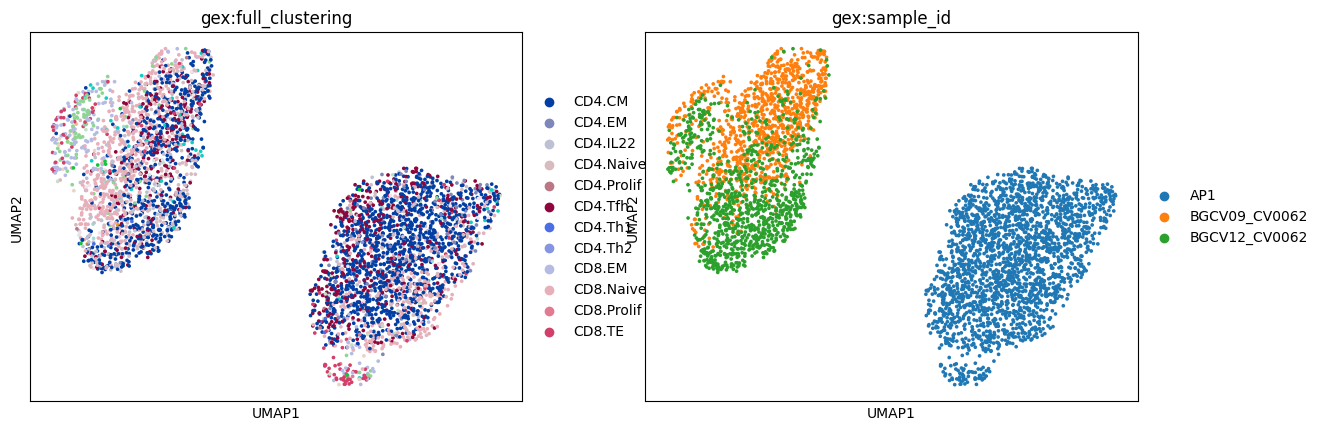

In [22]:
sc.pp.neighbors(mdata, use_rep="X_mvTCR")
sc.tl.umap(mdata)
sc.pl.umap(mdata, color=['gex:full_clustering', 'gex:sample_id'])

Note, that the results here show severe batch-effect and bad conservence of cell type. This is due to the limited amount of patients used, the low amount of epochs per training, and the limited runs for HPO. However, these values where choosen in order to have  short computation times for this tutorial.